Date created: July 13, 2022

---

## Project 2: Flow Over a Flat Plate
**Contributors:** Mason Friedberg, Brian Tan, Tyler Reiser      
**Summary:** Modeling the flow over a flat plate.  
       
---
#### Physics
We have a flat plate sitting somewhere in space. The flat plate has a uniform temperature, so the temperature at all points on the plate are equal, and the plate is stationary. In the space around the plate, there is a fluid with uniform temperature and starting velocity. So the temperature of the fluid at any point is equal and the fluid is moving since the horizontal velocity is greater than zero.

Let the fluid move uniformly towards the flat plate from left-to-right. Then there is some point where the fluid meets the leading edge of the plate and the temperature of the plate and fluid will difuse in one of the following ways:
    1. The fluid loses heat to the plate   
    2. The plate loses heat to the fluid   
    3. The temperature of the plate and fluid remain constant   
We will focus on the first two cases and make the assumption that the plate is only losing heat in the upward direction. In both of the first two cases, the fluid will continue to cover more of the plate as time passes. From the point that the fluid covers the least amount of the plate and the point where the fluid covers the entire plate, there is an additional diffusion happening as the fluid "sticks" to the surface of the plate. We will calculate the velocity first.

---

#### Finding the coupled system for F
We want to solve $G$, but need to know $F$ to solve $G$. $F$ is a third-order differential equation with three given boundary conditions. In order to solve this equation, we can represent the higher-order differential equation as a coupled system of first-order differential equations. This turns the problem into an initial value problem that can be solved easily with RK4. Look at [1] for reference on how to find this 1st degree representation.

The coupled system of differential equations that represent $F$ are:
$$ y_1' = y_2 $$
$$y_2' = y_3$$
$$y_3' = - \frac{1}{2} y_1 y_3 $$
and let the initial conditions be,   
$$y_1(0) = F(0) = 0$$
$$y_2(0) = F'(0) = 0$$
$$y_3(0) = F''(0) = u $$

The step size is given to us as $0.1$.

---
#### Fourth-order Runge Kutta
The algorithm is in one function that moves our initial guesses across time. Since we have a system of differential equations, at each step, we have to move each initial condition across time for every equation and RK4 tells us how we "average" the results of each output. The output is the value of each initial conditions at the next step in time.

In [1]:
import numpy as np
import random

def RK4(t,y1,y2,y3,dt):
    def equation_1(t,y1,y2,y3):
        return y2
    def equation_2(t,y1,y2,y3):
        return y3
    def equation_3(t,y1,y2,y3):
        return (-1/2)*(y1*y3)
    
    k1 = np.array([0.,0.,0.])
    k2 = np.array([0.,0.,0.])
    k3 = np.array([0.,0.,0.])
    k4 = np.array([0.,0.,0.])

    k1[0] = dt*equation_1(t, y1, y2, y3)
    k1[1] = dt*equation_2(t, y1, y2, y3)
    k1[2] = dt*equation_3(t, y1, y2, y3)

    k2[0] = dt*equation_1(t + dt/2., y1 + k1[0]/2., y2 + k1[1]/2., y3 + k1[2]/2.)
    k2[1] = dt*equation_2(t + dt/2., y1 + k1[0]/2., y2 + k1[1]/2., y3 + k1[2]/2.)
    k2[2] = dt*equation_3(t + dt/2., y1 + k1[0]/2., y2 + k1[1]/2., y3 + k1[2]/2.)

    k3[0] = dt*equation_1(t + dt/2., y1 + k2[0]/2., y2 + k2[1]/2., y3 + k2[2]/2.)
    k3[1] = dt*equation_2(t + dt/2., y1 + k2[0]/2., y2 + k2[1]/2., y3 + k2[2]/2.)
    k3[2] = dt*equation_3(t + dt/2., y1 + k2[0]/2., y2 + k2[1]/2., y3 + k2[2]/2.)

    k4[0] = dt*equation_1(t + dt, y1 + k3[0], y2 + k3[1], y3 + k3[2])
    k4[1] = dt*equation_2(t + dt, y1 + k3[0], y2 + k3[1], y3 + k3[2])
    k4[2] = dt*equation_3(t + dt, y1 + k3[0], y2 + k3[1], y3 + k3[2])

    y1 = y1 + (1./6.)*(k1[0] + 2.*k2[0] + 2.*k3[0] + k4[0])
    y2 = y2 + (1./6.)*(k1[1] + 2.*k2[1] + 2.*k3[1] + k4[1])
    y3 = y3 + (1./6.)*(k1[2] + 2.*k2[2] + 2.*k3[2] + k4[2])
    
    return np.array([y1, y2, y3])

---
### Shooting Method
The idea behind the shooting method is to check how well our guess of $u$ is by calculating the boundary residual. To do this, we compute the difference between the given value of $F'(\inf)$ and value of $F'$ that our model outputs. This is a root-finding problem and we can use **bisection method**. 

In [14]:
def guess_to_residual(u,RK4):
    t0 = 0.1
    dt = 0.1
    tmax = 10.1
    vector_t = np.arange(t0,tmax,dt)
    n = len(vector_t)
    
    rk4_velocity_data = np.zeros((n,3))
    rk4_velocity_data[0,0] = 0
    rk4_velocity_data[0,1] = 0
    rk4_velocity_data[0,2] = u
    for i in range(n-1): 
        rk4_velocity_data[i+1,:] = RK4(vector_t[i], rk4_velocity_data[i,0], rk4_velocity_data[i,1], rk4_velocity_data[i,2], dt)
        
    y = rk4_velocity_data[len(rk4_velocity_data)-1]
    r = y[1] - 1
    return r
print("Here is the boundary residual of F'  ", guess_to_residual(.5,RK4))

Here is the boundary residual of F'   0.3137254218503429


#### Root-finding

<IPython.core.display.Javascript object>


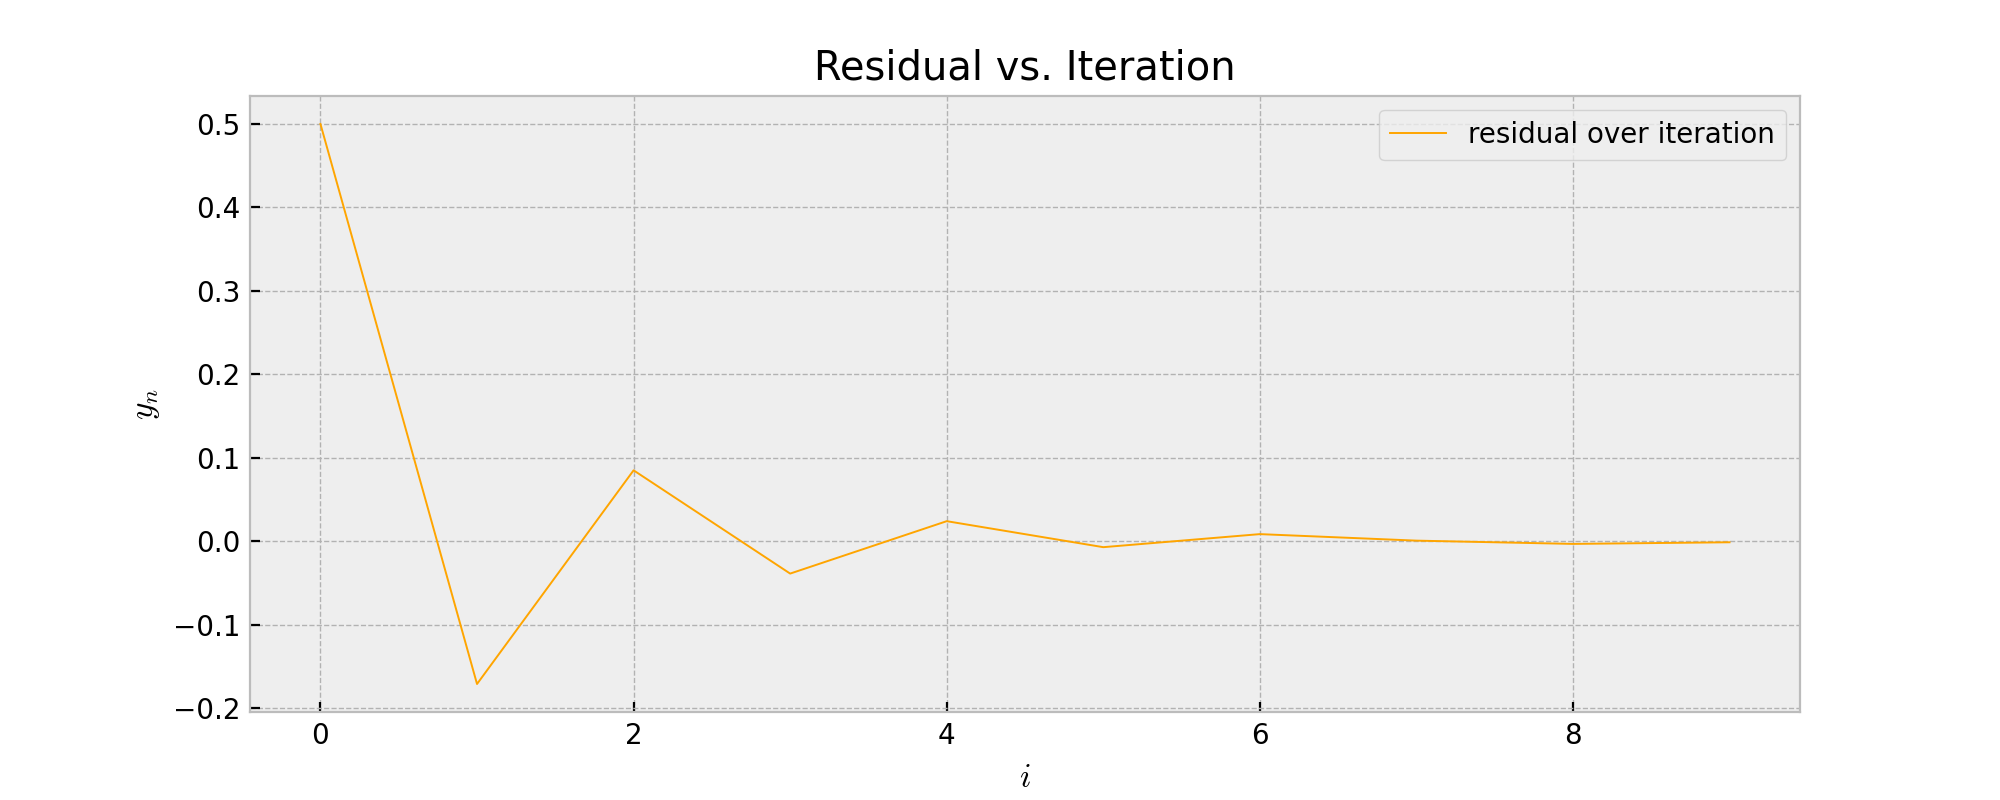

this is the final value for y3:  0.33205734613177407


In [3]:
import matplotlib.pyplot as plt
%matplotlib notebook
plt.style.use('bmh')

def bisect(u0,guess_to_residual,RK4):
    iteration = []; residual = []
    r1 = 0; r1g = 0
    itt = 0
    r0 = guess_to_residual(u0,RK4)
    if r0 > 0:
        while r1 >= 0 and r1g < 1000:
            u1 = 1/random.randint(1,1000)
            r1 = guess_to_residual(u1,RK4)
            r1g += 1
    elif r0 < 0:
        while r1 <= 0 and r1g < 1000:
            u1 = 1/random.randint(1,1000)
            r1 = guess_to_residual(u1,RK4)
            r1g += 1
        ll,gg = r0,u0
        r0,u0 = r1,u1
        r1,u1 = ll,gg   
    r = 0.5
    residual.append(r)
    iteration.append(int(itt))
    while abs(r) > 10**(-15) and itt < 1000:
        unew = (u1+u0)/2
        r = guess_to_residual(unew,RK4)
        residual.append(r)
        if r < 0:
            u1 = unew
        elif r >= 0:
            u0 = unew
        itt += 1
        iteration.append(int(itt))
    return [iteration, residual, unew]

def plot_residual_F(eta,bisect):
    x,y,y3 = bisect(0.5,guess_to_residual,RK4)
    x_plot = np.arange((len(x)+1)/5)
    n = len(x_plot)
    
    plt.figure(figsize=(10,4))
    plt.title('Residual vs. Iteration')
    plt.ylabel('$y_n$')
    plt.xlabel('$i$')
    plt.plot(x_plot, y[:n], color='orange', label="residual over iteration", linewidth='0.7')
    plt.legend()
    plt.show()
    return print("this is the final value for y3: ", y3)

plot_residual_F(0,bisect)

#### Plotting a data stream

<IPython.core.display.Javascript object>


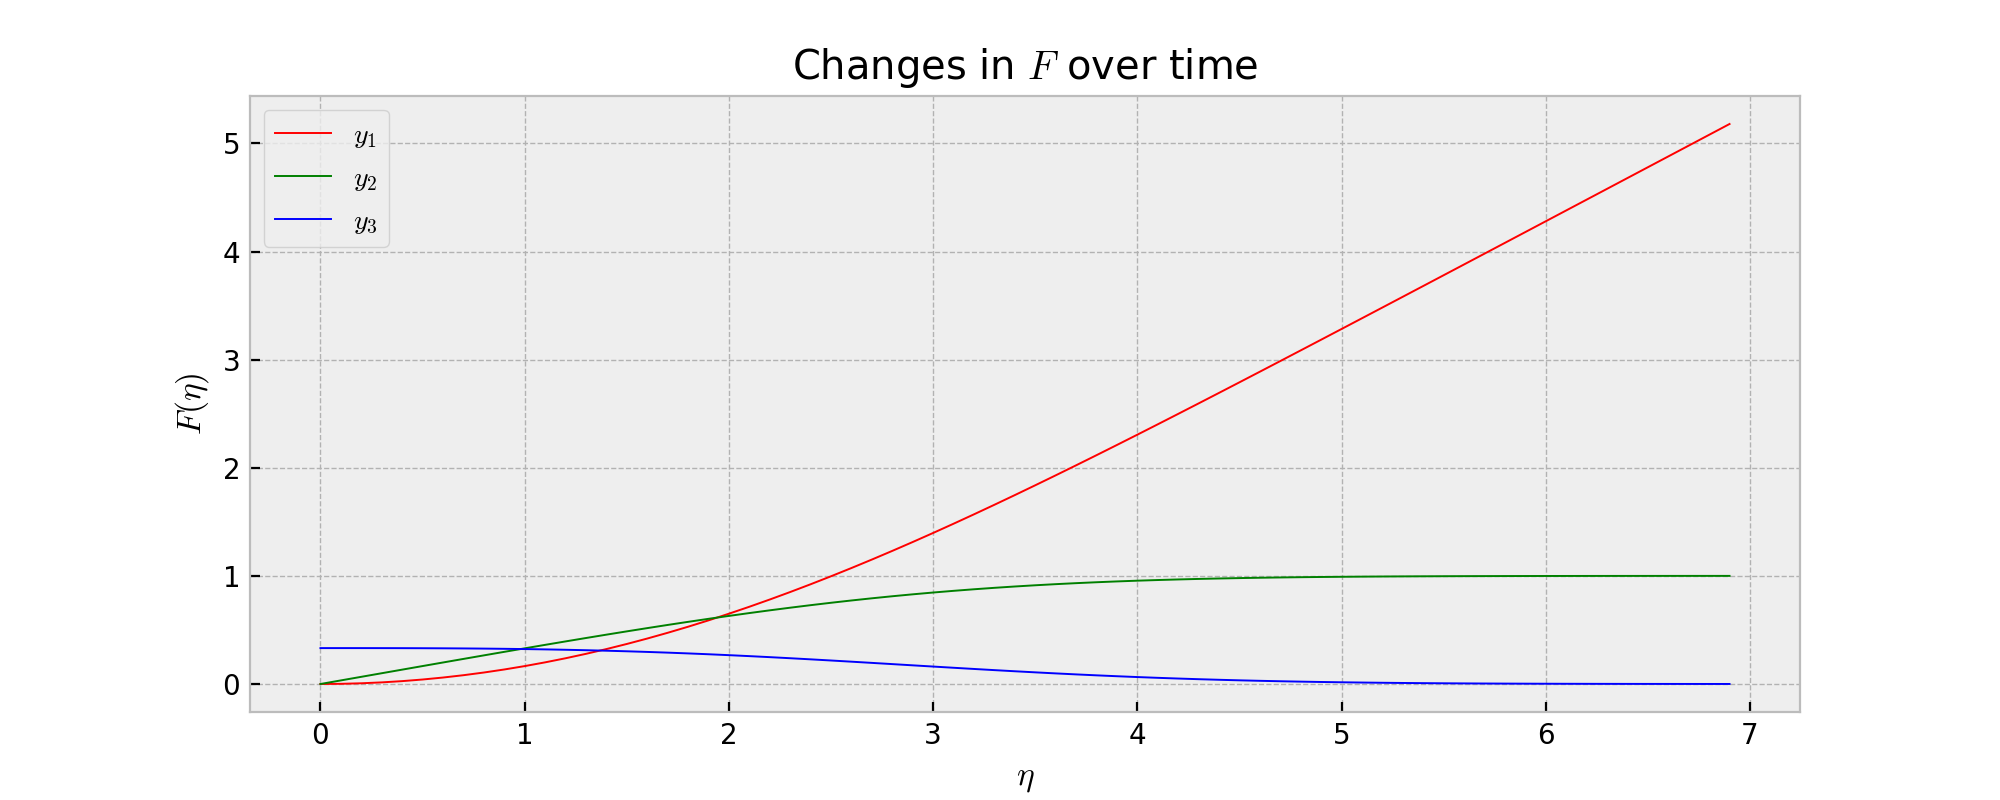

In [20]:
y1 = 0
y2 = 0
y3 = bisect(0.5,guess_to_residual,RK4)[2]
eta = 5.5

t0 = 0
dt = 0.1
tmax = 10
vector_t = np.arange(t0,tmax,dt)
n = len(vector_t)

rk4_velocity_data = np.zeros((n,3))
rk4_velocity_data[0,0] = y1
rk4_velocity_data[0,1] = y2
rk4_velocity_data[0,2] = y3
for i in range(n-1): 
    rk4_velocity_data[i+1,:] = RK4(vector_t[i], rk4_velocity_data[i,0], rk4_velocity_data[i,1], rk4_velocity_data[i,2], dt)

plt.figure(figsize=(10,4))
plt.title("Changes in $F$ over time")
plt.ylabel('$F(\eta)$')
plt.xlabel('$\eta$')
plt.plot(vector_t[:int(n*(0.7))], rk4_velocity_data[:int(n*(0.7)),0], color='r', label="$y_1$", linewidth='0.7')
plt.plot(vector_t[:int(n*(0.7))], rk4_velocity_data[:int(n*(0.7)),1], color='g', label="$y_2$", linewidth='0.7')
plt.plot(vector_t[:int(n*(0.7))], rk4_velocity_data[:int(n*(0.7)),2], color='b', label="$y_3$", linewidth='0.7')
plt.legend()
plt.show()

---
#### Solving G
Now that $F$ is solved, we create another coupled system out of $G$, which is given as a second order differential equation. 

Let the coupled system of first order differential equations be,
$$y_1' = y_2$$
$$y_2' = y_3$$
$$y_3' = - \frac{1}{2} y_1 y_3 $$
$$y_4' = y_5$$
$$y_5' = - \frac{1}{2} Pr y_1 y_5 $$

with initial conditions,   
$$y_4(0) = G(0) = 1$$ 
$$y_5(0) = G'(0) = u$$

and the process follows the process outlined above.

<IPython.core.display.Javascript object>


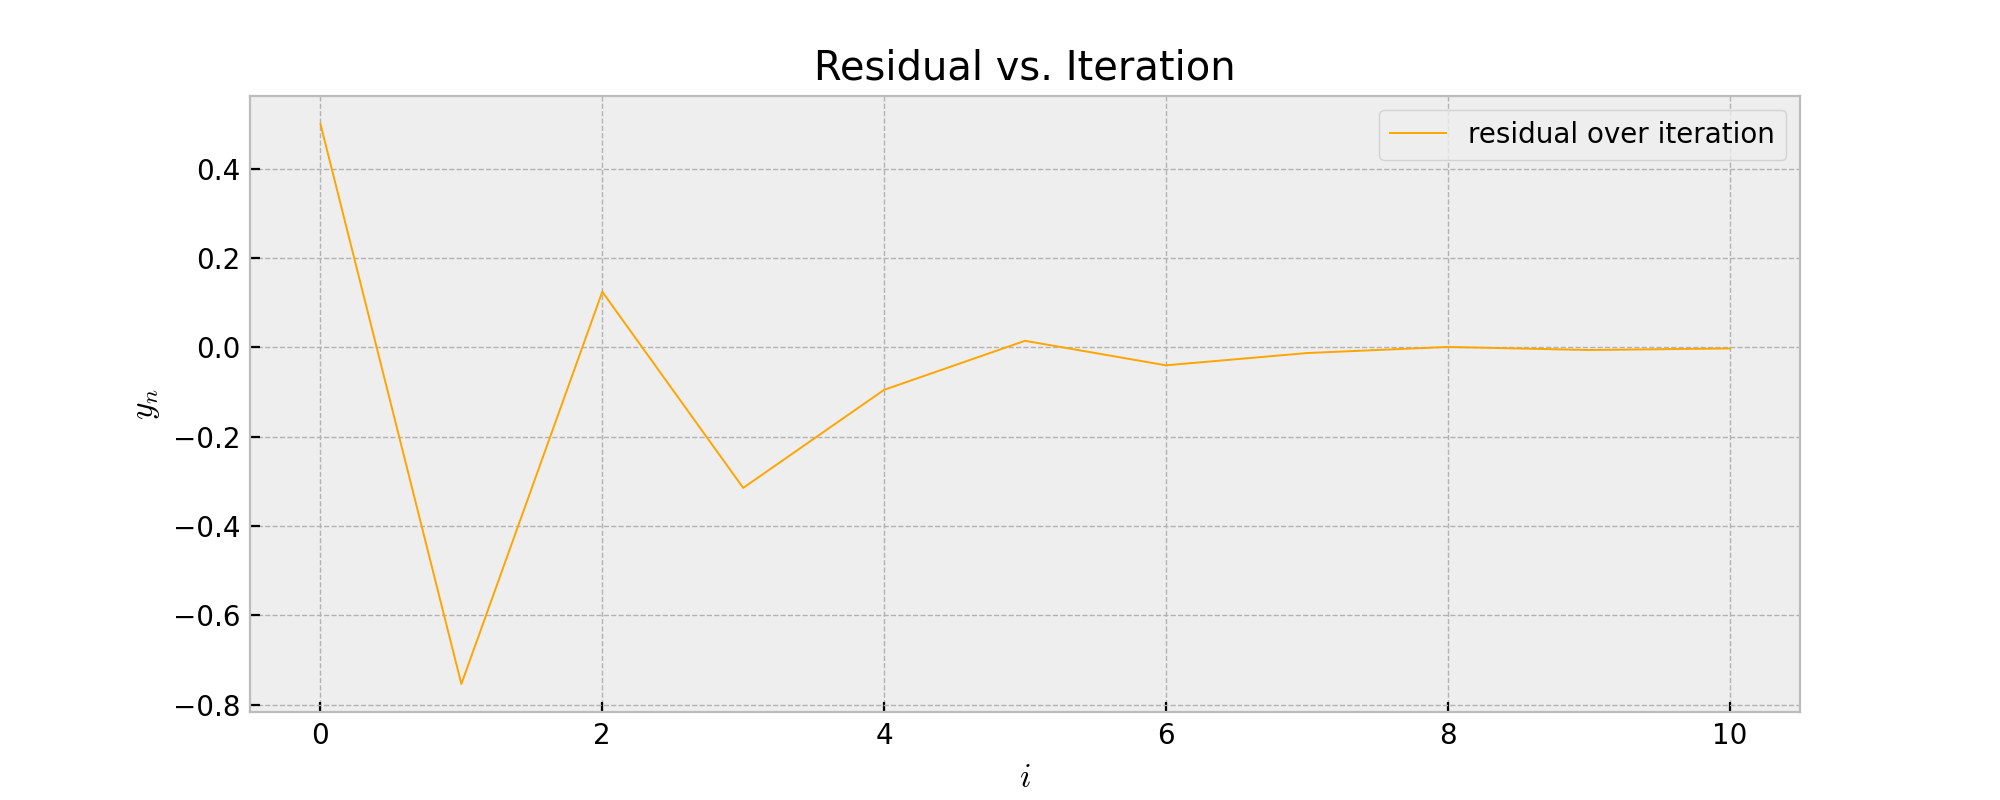

Best value for $y_5$:  -0.5687037663054153


In [5]:
def RK4_temp(t,y1,y2,y3,y4,y5,dt,pr=5):
    def equation_1(t,y1,y2,y3,y4,y5):
        return y2
    def equation_2(t,y1,y2,y3,y4,y5):
        return y3
    def equation_3(t,y1,y2,y3,y4,y5):
        return (-1/2)*(y1*y3)
    def equation_4(t,y1,y2,y3,y4,y5):
        return y5
    def equation_5(t,y1,y2,y3,y4,y5):
        return (-1/2)*pr*(y1*y5)
    
    k1 = np.array([0., 0., 0., 0., 0.])
    k2 = np.array([0., 0., 0., 0., 0.])
    k3 = np.array([0., 0., 0., 0., 0.])
    k4 = np.array([0., 0., 0., 0., 0.])

    k1[0] = dt*equation_1(t, y1, y2, y3, y4, y5)
    k1[1] = dt*equation_2(t, y1, y2, y3, y4, y5)
    k1[2] = dt*equation_3(t, y1, y2, y3, y4, y5)
    k1[3] = dt*equation_4(t, y1, y2, y3, y4, y5)
    k1[4] = dt*equation_5(t, y1, y2, y3, y4, y5)

    k2[0] = dt*equation_1(t + dt/2., y1 + k1[0]/2., y2 + k1[1]/2., y3 + k1[2]/2., y4 + k1[2]/2., y5 + k1[2]/2.)
    k2[1] = dt*equation_2(t + dt/2., y1 + k1[0]/2., y2 + k1[1]/2., y3 + k1[2]/2., y4 + k1[2]/2., y5 + k1[2]/2.)
    k2[2] = dt*equation_3(t + dt/2., y1 + k1[0]/2., y2 + k1[1]/2., y3 + k1[2]/2., y4 + k1[2]/2., y5 + k1[2]/2.)
    k2[3] = dt*equation_4(t + dt/2., y1 + k1[0]/2., y2 + k1[1]/2., y3 + k1[2]/2., y4 + k1[2]/2., y5 + k1[2]/2.)
    k2[4] = dt*equation_5(t + dt/2., y1 + k1[0]/2., y2 + k1[1]/2., y3 + k1[2]/2., y4 + k1[2]/2., y5 + k1[2]/2.)

    k3[0] = dt*equation_1(t + dt/2., y1 + k2[0]/2., y2 + k2[1]/2., y3 + k2[2]/2., y4 + k2[2]/2., y5 + k2[2]/2.)
    k3[1] = dt*equation_2(t + dt/2., y1 + k2[0]/2., y2 + k2[1]/2., y3 + k2[2]/2., y4 + k2[2]/2., y5 + k2[2]/2.)
    k3[2] = dt*equation_3(t + dt/2., y1 + k2[0]/2., y2 + k2[1]/2., y3 + k2[2]/2., y4 + k2[2]/2., y5 + k2[2]/2.)
    k3[3] = dt*equation_4(t + dt/2., y1 + k2[0]/2., y2 + k2[1]/2., y3 + k2[2]/2., y4 + k2[2]/2., y5 + k2[2]/2.)
    k3[4] = dt*equation_5(t + dt/2., y1 + k2[0]/2., y2 + k2[1]/2., y3 + k2[2]/2., y4 + k2[2]/2., y5 + k2[2]/2.)

    k4[0] = dt*equation_1(t + dt, y1 + k3[0], y2 + k3[1], y3 + k3[2], y4 + k3[2], y5 + k3[2])
    k4[1] = dt*equation_2(t + dt, y1 + k3[0], y2 + k3[1], y3 + k3[2], y4 + k3[2], y5 + k3[2])
    k4[2] = dt*equation_3(t + dt, y1 + k3[0], y2 + k3[1], y3 + k3[2], y4 + k3[2], y5 + k3[2])
    k4[3] = dt*equation_4(t + dt, y1 + k3[0], y2 + k3[1], y3 + k3[2], y4 + k3[2], y5 + k3[2])
    k4[4] = dt*equation_5(t + dt, y1 + k3[0], y2 + k3[1], y3 + k3[2], y4 + k3[2], y5 + k3[2])

    y1 = y1 + (1./6.)*(k1[0] + 2.*k2[0] + 2.*k3[0] + k4[0])
    y2 = y2 + (1./6.)*(k1[1] + 2.*k2[1] + 2.*k3[1] + k4[1])
    y3 = y3 + (1./6.)*(k1[2] + 2.*k2[2] + 2.*k3[2] + k4[2])
    y4 = y4 + (1./6.)*(k1[3] + 2.*k2[3] + 2.*k3[3] + k4[3])
    y5 = y5 + (1./6.)*(k1[4] + 2.*k2[4] + 2.*k3[4] + k4[4])
    
    return np.array([y1, y2, y3, y4, y5])

def guess_to_residual_G(u,RK4_temp):
    t0 = 0
    dt = 0.1
    tmax = 10
    vector_t = np.arange(t0,tmax,dt)
    n = len(vector_t)
    
    rk4_temp_data = np.zeros((n,5))
    rk4_temp_data[0, 0] = y1
    rk4_temp_data[0, 1] = y2
    rk4_temp_data[0, 2] = y3
    rk4_temp_data[0, 3] = 1
    rk4_temp_data[0, 4] = u
    for i in range(n-1): 
        rk4_temp_data[i+1,:] = RK4_temp(vector_t[i], rk4_temp_data[i,0], rk4_temp_data[i,1], 
                                         rk4_temp_data[i,2], rk4_temp_data[i,3], rk4_temp_data[i,4],  dt)
        
    y = rk4_temp_data[len(rk4_temp_data)-1]
    r = y[3] 
    return r

def plot_residual_G(bisect):
    x,y,y5 = bisect(-2,guess_to_residual_G,RK4_temp)
    x_plot = np.arange((len(x)+1)/5)
    n = len(x_plot)
    plt.figure(figsize=(10,4))
    plt.title('Residual vs. Iteration')
    plt.ylabel('$y_n$')
    plt.xlabel('$i$')
    plt.plot(x_plot, y[:n], color='orange', label="residual over iteration", linewidth='0.7')
    plt.legend()
    plt.show()
    return print("Best value for $y_5$: ", y5)

plot_residual_G(bisect)

#### Plotting all values over time

<IPython.core.display.Javascript object>


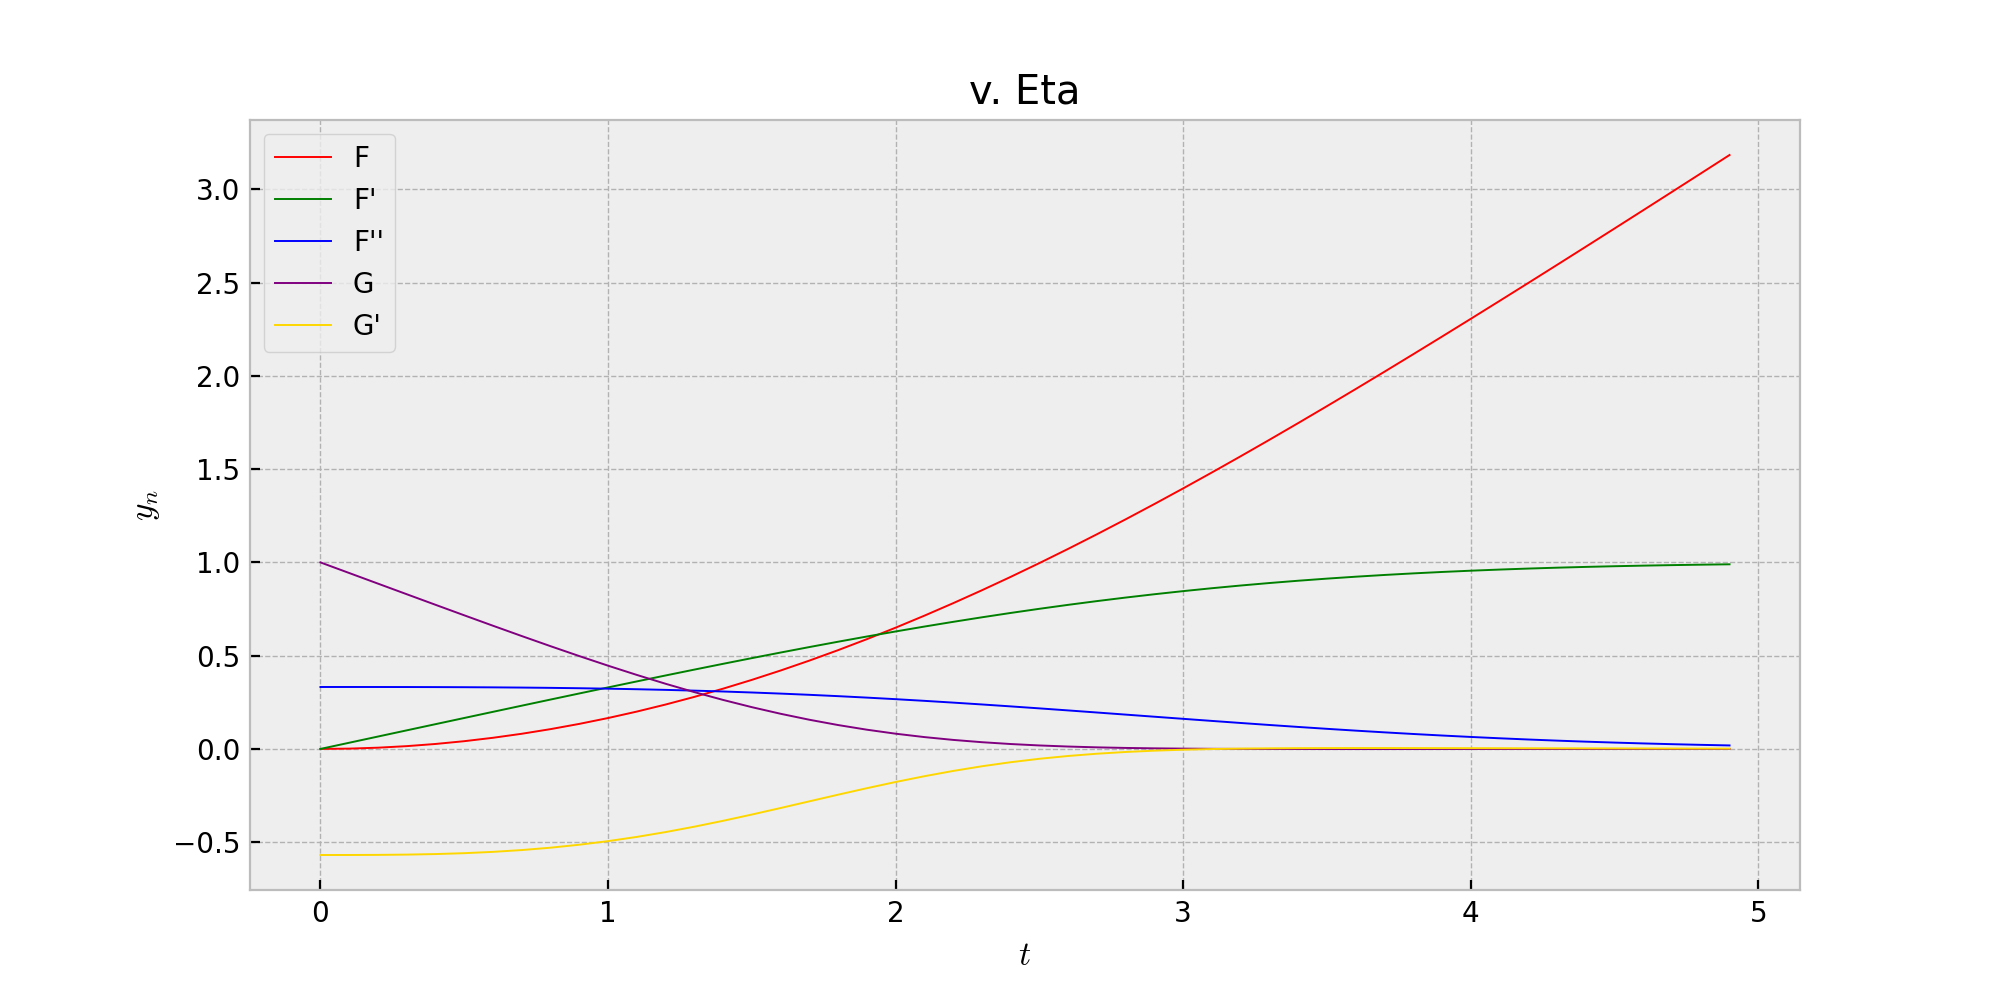

In [6]:
y1 = 0
y2 = 0
y3 = bisect(0.5,guess_to_residual,RK4)[2]
y4 = 1
y5 = bisect(-2,guess_to_residual_G,RK4_temp)[2]
       
rk4_data = np.zeros((n,5))
rk4_data[0,0] = y1
rk4_data[0,1] = y2
rk4_data[0,2] = y3
rk4_data[0,3] = y4
rk4_data[0,4] = y5

for i in range(n-1): 
        rk4_data[i+1,:] = RK4_temp(vector_t[i], rk4_data[i,0], rk4_data[i,1], rk4_data[i,2], rk4_data[i,3], rk4_data[i,4],  dt)
    
plt.figure(figsize=(10,5))
plt.title('v. Eta')
plt.ylabel('$y_n$')
plt.xlabel('$t$')

plt.plot(vector_t[:int(n*(0.5))], rk4_data[:int(n*(0.5)),0], color='red', label="F", linewidth='0.7')
plt.plot(vector_t[:int(n*(0.5))], rk4_data[:int(n*(0.5)),1], color='green', label="F'", linewidth='0.7')
plt.plot(vector_t[:int(n*(0.5))], rk4_data[:int(n*(0.5)),2], color='blue', label="F''", linewidth='0.7')
plt.plot(vector_t[:int(n*(0.5))], rk4_data[:int(n*(0.5)),3], color='purple', label="G", linewidth='0.7')
plt.plot(vector_t[:int(n*(0.5))], rk4_data[:int(n*(0.5)),4], color='gold', label="G'", linewidth='0.7')
plt.legend()
plt.show()

#### Tabulated Data

In [7]:
import pandas as pd

df = pd.DataFrame(rk4_data,columns=['F',"F'","F''",'G',"G'"])
df['Eta'] = np.arange(0,10,.1)
print(df)

           F        F'           F''             G            G'  Eta
0   0.000000  0.000000  3.320573e-01  1.000000e+00 -5.687038e-01  0.0
1   0.001660  0.033206  3.320482e-01  9.431294e-01 -5.686251e-01  0.1
2   0.006641  0.066408  3.319838e-01  8.862644e-01 -5.680743e-01  0.2
3   0.014941  0.099599  3.318094e-01  8.294493e-01 -5.665808e-01  0.3
4   0.026560  0.132764  3.314699e-01  7.727759e-01 -5.636799e-01  0.4
..       ...       ...           ...           ...           ...  ...
95  7.779212  1.000000  6.292236e-08 -5.206286e-10  1.296185e-08  9.5
96  7.879212  1.000000  4.254435e-08 -3.088378e-10  8.859691e-09  9.6
97  7.979212  1.000000  2.862270e-08 -1.643298e-10  6.024650e-09  9.7
98  8.079212  1.000000  1.916070e-08 -6.623899e-11  4.075762e-09  9.8
99  8.179212  1.000000  1.276274e-08  7.783887e-16  2.743163e-09  9.9

[100 rows x 6 columns]


#### Data

<IPython.core.display.Javascript object>


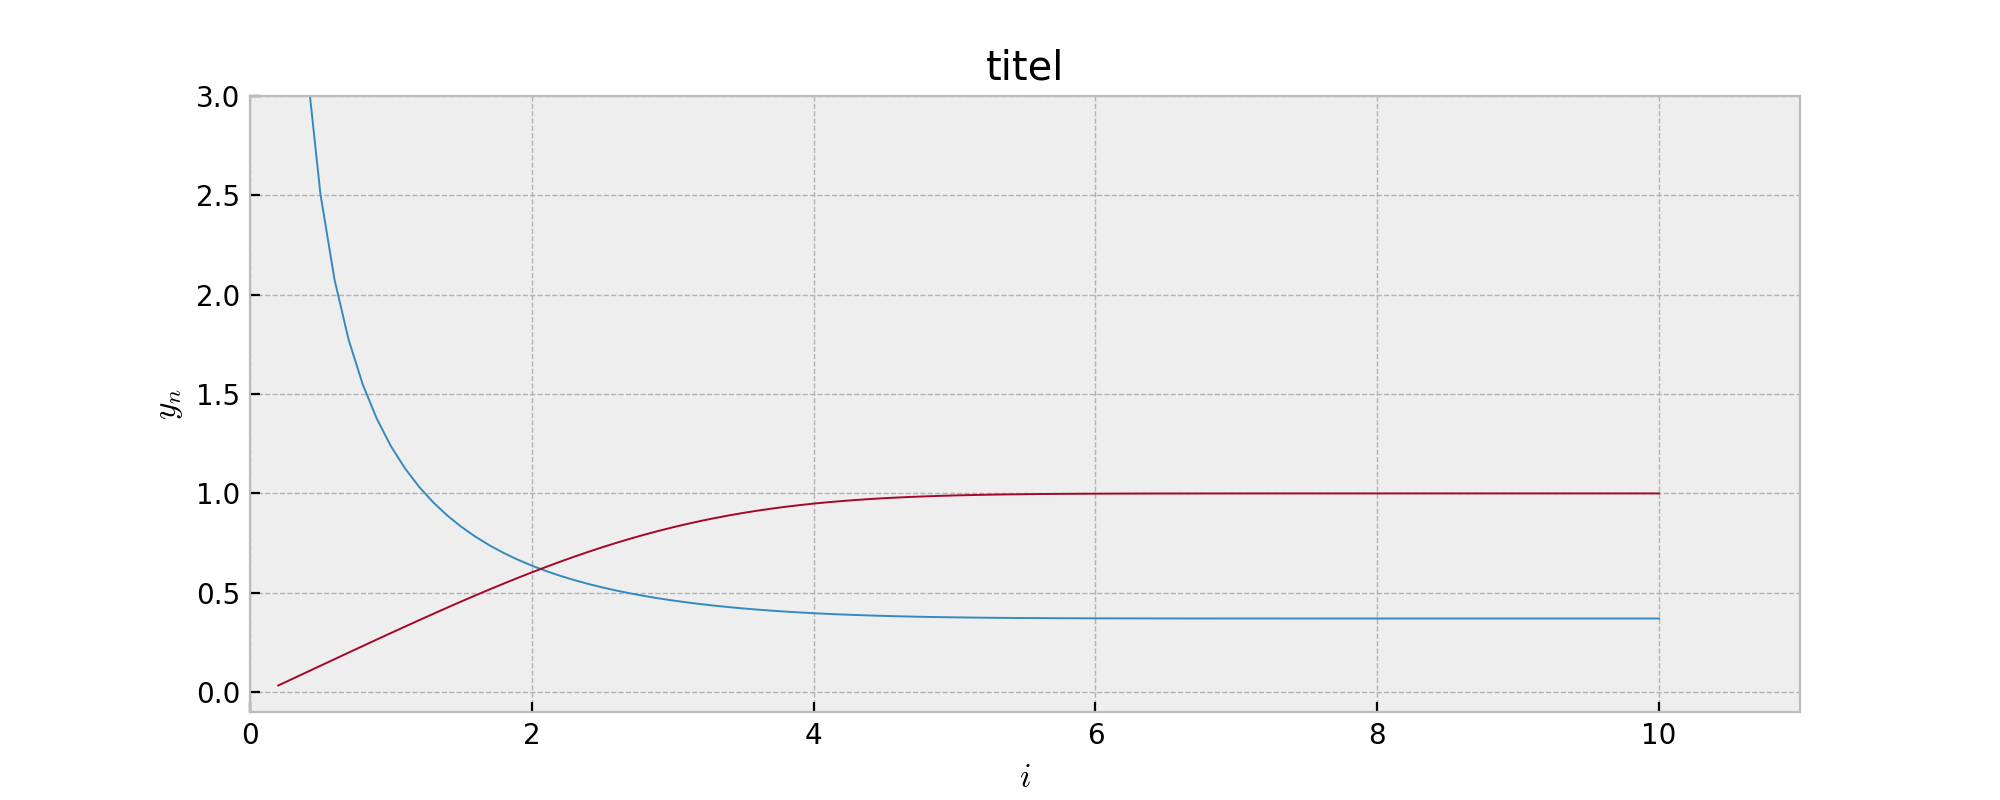

In [8]:
#A (1/2) * (eta*F'(eta) - F(eta)^(-1/2)
#B -> F'(eta)

eta = np.arange(0.1,10.1,.1)

A_vals = (1/2)*(np.array(eta[1:])*np.array(df["F'"][1:]) - np.array(df['F'][1:]))**(-1/2)
B_vals = np.array(df["F'"][1:])
plt.figure(figsize=(10,4))
plt.axis([0, 11, -0.1, 3])
plt.title('titel')
plt.ylabel('$y_n$')
plt.xlabel('$i$')
plt.plot(eta[1:], A_vals,linewidth='0.7')
plt.plot(eta[1:], B_vals,linewidth='0.7')

#### Data

<IPython.core.display.Javascript object>


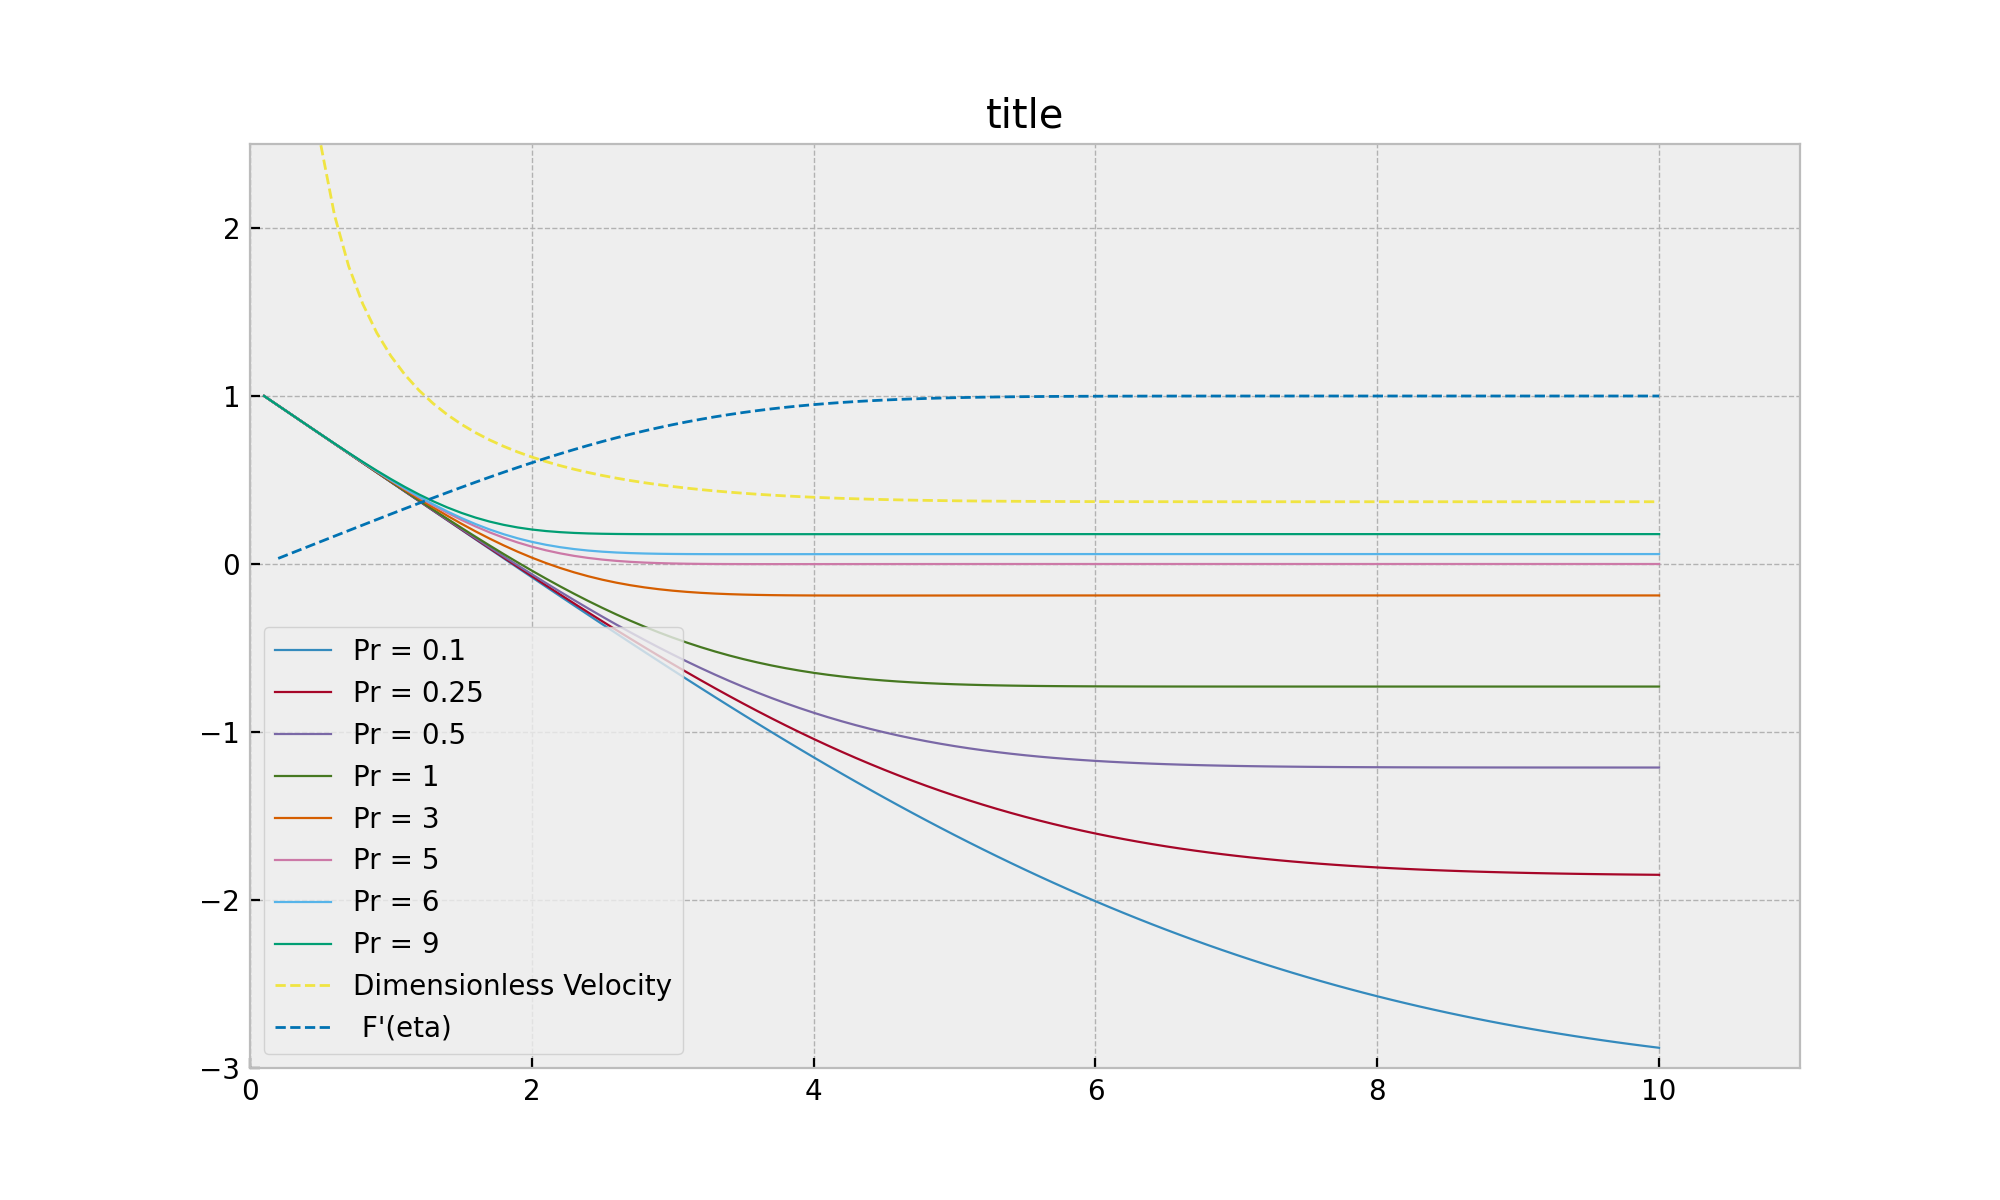

In [9]:
pr_vals = [0.1,.25,.5,1,3,5,6,9]
plt.figure(figsize=(10,6))
plt.axis([0, 11, -3, 2.5])
plt.title("title")
for pr in pr_vals:
    for i in range(n-1): 
        rk4_data[i+1,:] = RK4_temp(vector_t[i], rk4_data[i,0], rk4_data[i,1], rk4_data[i,2], rk4_data[i,3], rk4_data[i,4],  dt, pr)
    plt.plot(eta, rk4_data[:,3], label=f'Pr = {pr}', linewidth='0.8')
    
plt.plot(eta[1:], A_vals[:], label='Dimensionless Velocity', linewidth='1', linestyle='--')
plt.plot(eta[1:], B_vals[:], label=" F'(eta)", linewidth='1', linestyle='--')
plt.legend()

<IPython.core.display.Javascript object>


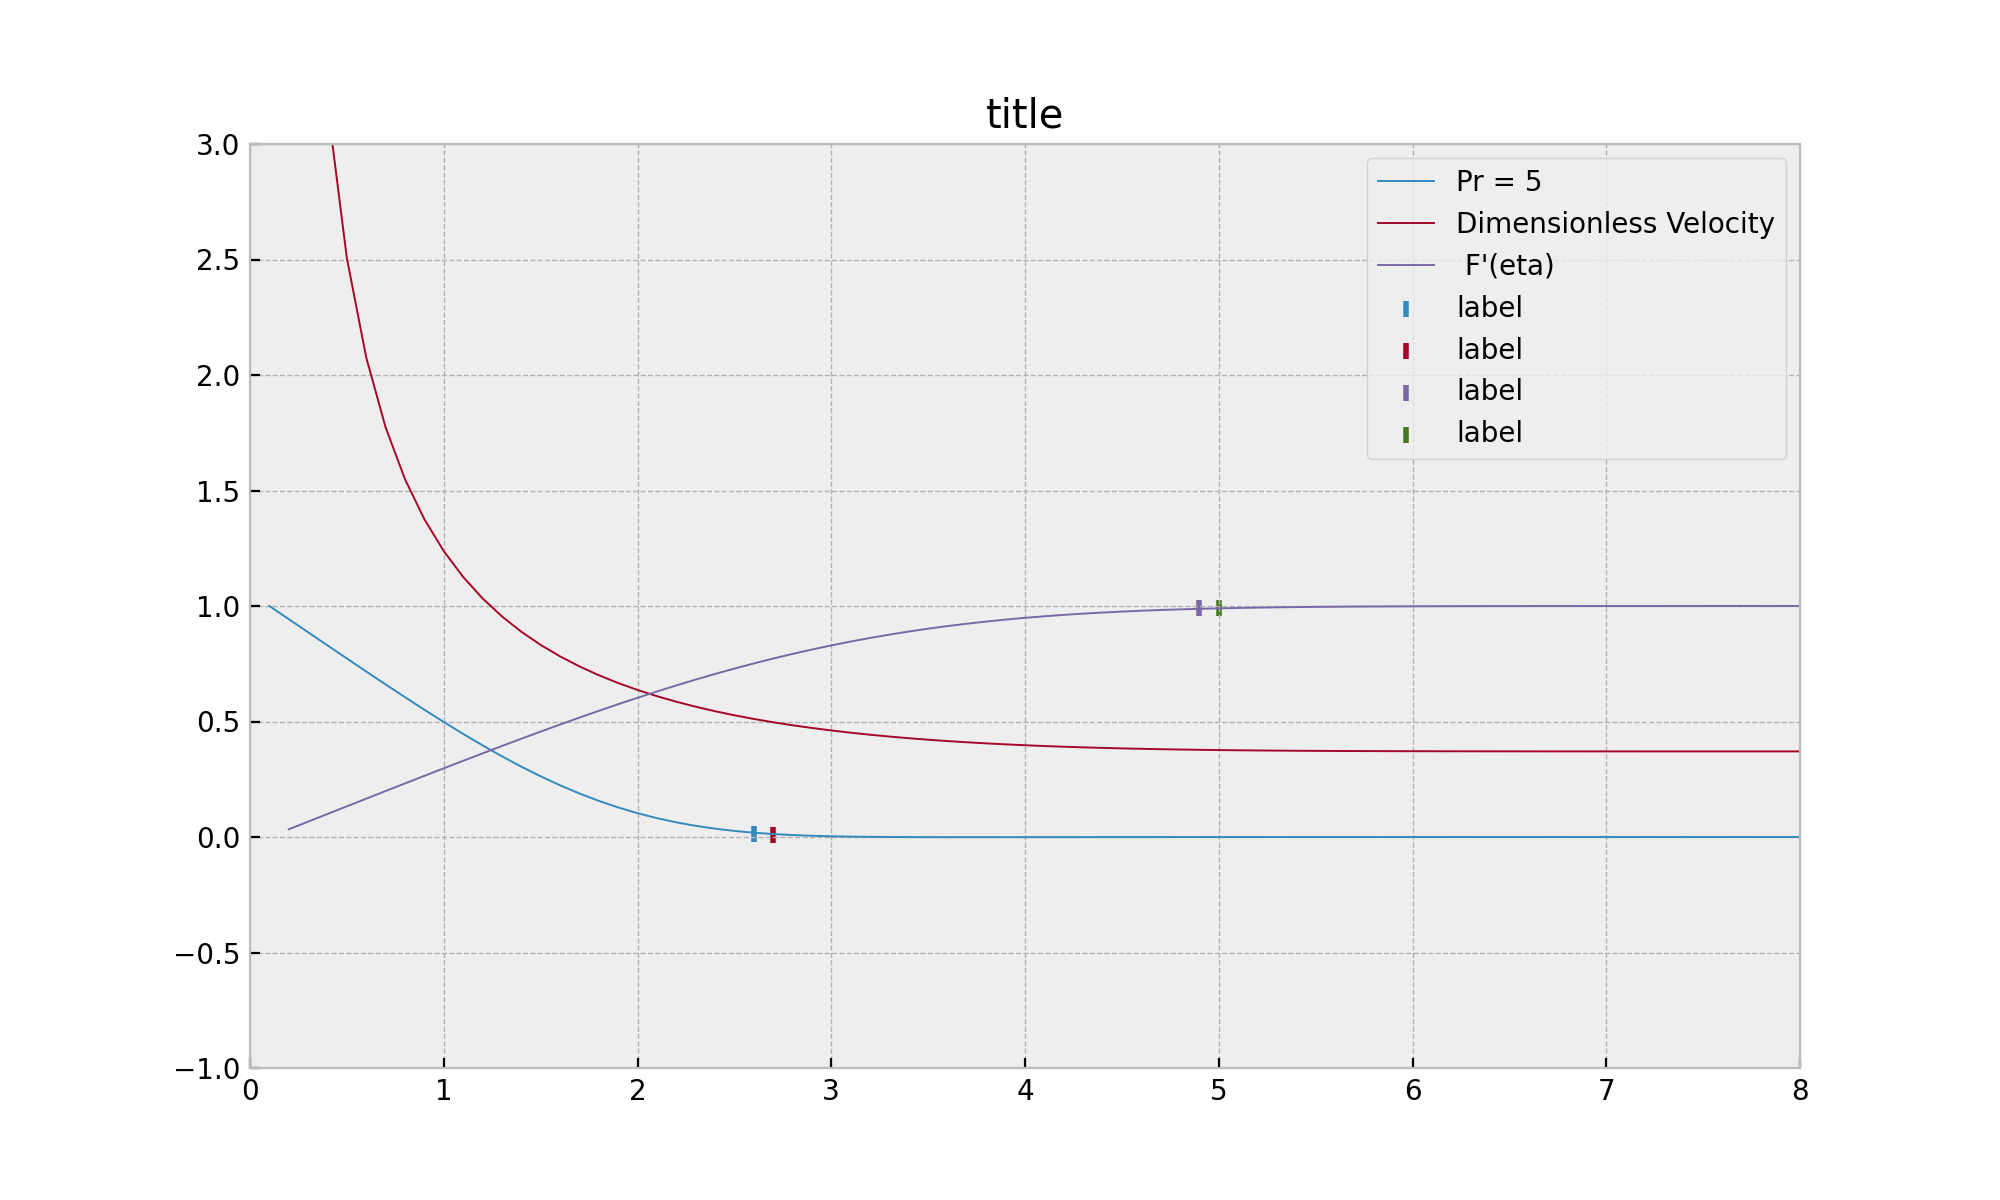

In [10]:
def find_eta_t(bound,df):
    for i in range(len(df['G'])):
        if df['G'][i] <= bound:
            lower_eta_t = np.array([df['Eta'][i-1],df['G'][i-1]])
            upper_eta_t = np.array([df['Eta'][i],df['G'][i]])
            return lower_eta_t, upper_eta_t

def find_eta_m(bound,df):
    for i in range(len(df["F'"])):
        if df["F'"][i] >= bound:
            lower_eta_m = np.array([df['Eta'][i-1],df["F'"][i-1]])
            upper_eta_m = np.array([df['Eta'][i],df["F'"][i]])
            return lower_eta_m, upper_eta_m

pr_vals = [5]
plt.figure(figsize=(10,6))
plt.axis([0, 8, -1, 3])
plt.title("title")
for pr in pr_vals:
    for i in range(n-1): 
        rk4_data[i+1,:] = RK4_temp(vector_t[i], rk4_data[i,0], rk4_data[i,1], rk4_data[i,2], rk4_data[i,3], rk4_data[i,4],  dt, pr)
    plt.plot(eta,rk4_data[:,3],label = f'Pr = {pr}', linewidth='0.7')
plt.plot(eta[1:], A_vals, label='Dimensionless Velocity', linewidth='0.7')
plt.plot(eta[1:], B_vals, label=" F'(eta)", linewidth='0.7')
plt.scatter(find_eta_t(0.01,df)[0][0], find_eta_t(0.01,df)[0][1], label='label', marker='|')
plt.scatter(find_eta_t(0.01,df)[1][0], find_eta_t(0.01,df)[1][1], label='label',marker='|')
plt.scatter(find_eta_m(0.99,df)[0][0], find_eta_m(0.99,df)[0][1], label='label', marker='|')
plt.scatter(find_eta_m(0.99,df)[1][0], find_eta_m(0.99,df)[1][1], label='label',marker='|')
plt.legend()